In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Load the CSV
df = pd.read_csv("cleanedToyota.csv", parse_dates=['Date'])
df = df[['Date', 'High']].dropna()
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Optional: resample to daily/monthly if needed
# df = df.resample('D').ffill()

# Split data
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


## ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train['High'], order=(5,1,0))  # example order
arima_result = arima_model.fit()

forecast_arima = arima_result.forecast(steps=len(test))
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
mape_arima = mean_absolute_percentage_error(test, forecast_arima)


C:\Users\rmlig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rmlig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rmlig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rmlig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

## Prophet

In [ ]:
from prophet import Prophet

df_prophet = df.reset_index().rename(columns={"Date": "ds", "High": "y"})
train_prophet = df_prophet[:train_size]
test_prophet = df_prophet[train_size:]

model_prophet = Prophet()
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future)

y_true = test_prophet['y'].values
y_pred = forecast_prophet.iloc[train_size:]['yhat'].values

rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
mape_prophet = mean_absolute_percentage_error(y_true, y_pred)


12:58:01 - cmdstanpy - INFO - Chain [1] start processing
12:58:02 - cmdstanpy - INFO - Chain [1] done processing


## XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# Create lag features
def create_lagged_features(df, lags=5):
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['High'].shift(i)
    df.dropna(inplace=True)
    return df

df_xgb = create_lagged_features(df.copy())
X = df_xgb.drop(columns=['High'])
y = df_xgb['High']

X_train, X_test = X[:train_size-5], X[train_size-5:]
y_train, y_test = y[:train_size-5], y[train_size-5:]

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)


## LSTM

In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['High']])
sequence_length = 60

def create_sequences(data):
    xs, ys = [], []
    for i in range(sequence_length, len(data)):
        xs.append(data[i-sequence_length:i])
        ys.append(data[i])
    return np.array(xs), np.array(ys)

X_lstm, y_lstm = create_sequences(scaled_data)
X_train_lstm, X_test_lstm = X_lstm[:train_size-sequence_length], X_lstm[train_size-sequence_length:]
y_train_lstm, y_test_lstm = y_lstm[:train_size-sequence_length], y_lstm[train_size-sequence_length:]

X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_lstm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_lstm, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 50)
        c0 = torch.zeros(2, x.size(0), 50)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

model_lstm = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

for epoch in range(10):  # train for more epochs for better performance
    model_lstm.train()
    optimizer.zero_grad()
    output = model_lstm(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

model_lstm.eval()
with torch.no_grad():
    y_pred_lstm = model_lstm(X_test_tensor).numpy()

y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_inv = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv))
mape_lstm = mean_absolute_percentage_error(y_test_lstm_inv, y_pred_lstm_inv)


## Evaluation

In [ ]:
print("RMSE & MAPE Summary:")
print(f"ARIMA  -> RMSE: {rmse_arima:.2f}, MAPE: {mape_arima:.2%}")
print(f"Prophet -> RMSE: {rmse_prophet:.2f}, MAPE: {mape_prophet:.2%}")
print(f"XGBoost -> RMSE: {rmse_xgb:.2f}, MAPE: {mape_xgb:.2%}")
print(f"LSTM    -> RMSE: {rmse_lstm:.2f}, MAPE: {mape_lstm:.2%}")


RMSE & MAPE Summary:
ARIMA  -> RMSE: 25.45, MAPE: 10.47%
Prophet -> RMSE: 41.95, MAPE: 19.23%
XGBoost -> RMSE: 17.87, MAPE: 4.89%
LSTM    -> RMSE: 52.21, MAPE: 21.74%


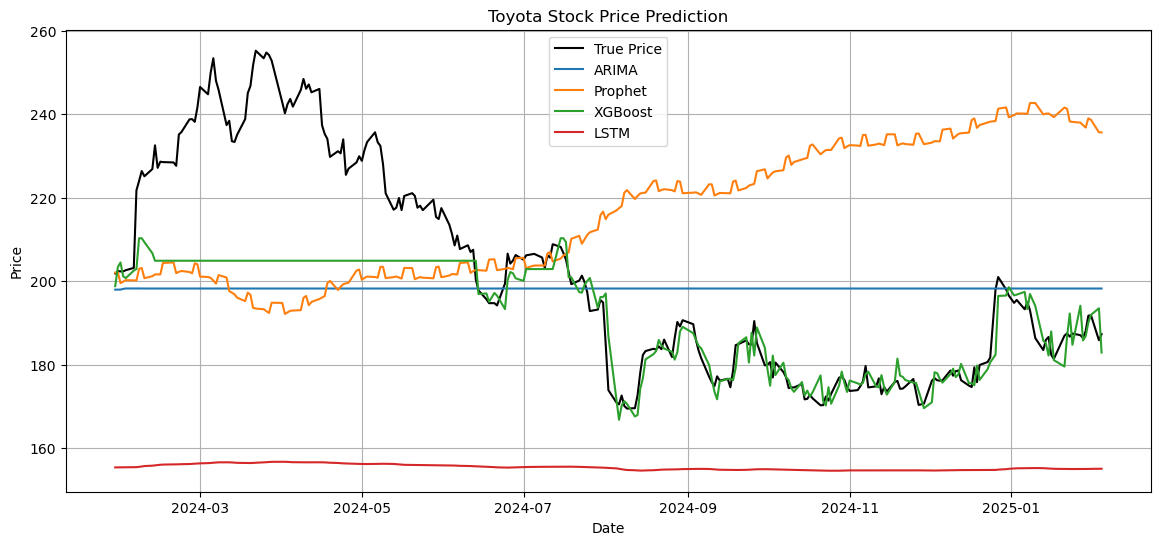

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(test.index, test['High'], label='True Price', color='black')
plt.plot(test.index, forecast_arima, label='ARIMA')
plt.plot(test.index, y_pred, label='Prophet')
plt.plot(test.index[-len(y_pred_xgb):], y_pred_xgb, label='XGBoost')
plt.plot(test.index[-len(y_pred_lstm_inv):], y_pred_lstm_inv, label='LSTM')
plt.title('Toyota Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


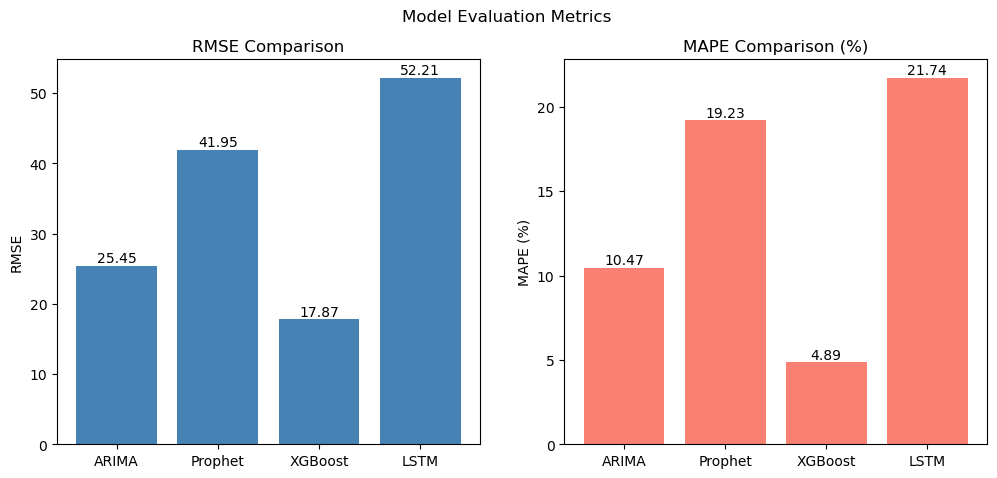

In [ ]:
models = ['ARIMA', 'Prophet', 'XGBoost', 'LSTM']
rmse_scores = [rmse_arima, rmse_prophet, rmse_xgb, rmse_lstm]
mape_scores = [mape_arima, mape_prophet, mape_xgb, mape_lstm]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# RMSE Bar Plot
bars_rmse = ax[0].bar(models, rmse_scores, color='steelblue')
ax[0].set_title("RMSE Comparison")
ax[0].set_ylabel("RMSE")
ax[0].bar_label(bars_rmse, fmt='%.2f')  # Show values with 2 decimal places

# MAPE Bar Plot
bars_mape = ax[1].bar(models, [m * 100 for m in mape_scores], color='salmon')
ax[1].set_title("MAPE Comparison (%)")
ax[1].set_ylabel("MAPE (%)")
ax[1].bar_label(bars_mape, fmt='%.2f')  # Show values with 2 decimal places

plt.suptitle("Model Evaluation Metrics")
plt.show()

